In [1]:
println("Hello World")

Hello World


In [1]:
using PyPlot, Random, FFTW
using LinearAlgebra


In [13]:
nx, ny = 64, 64 # number of grid points
Lx, Ly = 2.0*pi, 2.0*pi      # size of t size of the domain in each direction

(6.283185307179586, 6.283185307179586)

In [14]:
dx, dy = Lx/nx, Ly/ny
x = 0:dx:Lx-dx
y = 0:dy:Ly-dy

0.0:0.09817477042468103:6.1850105367549055

In [15]:
X  = zeros(nx,ny)
Y  = zeros(nx,ny)
for j in 1:ny, i in 1:nx
     X[i, j] = x[i]
     Y[i, j] = y[j]
end

In [16]:
k  = 2.0*pi/Lx * [0:nx/2; -nx/2+1:-1];
l  = 2.0*pi/Ly * [0:ny/2; -ny/2+1:-1];

	Kx = zeros(nx, ny)
	Ky = zeros(nx, ny)
	for j in 1:ny, i in 1:nx
	    Kx[i, j] = k[i] #cria o grid em Kx
	    Ky[i, j] = l[j] #cria o grid em Ky
	end

In [17]:
r = @. sqrt(Kx^2+Ky^2)

64×64 Matrix{Float64}:
  0.0   1.0       2.0       3.0      …   3.0       2.0       1.0
  1.0   1.41421   2.23607   3.16228      3.16228   2.23607   1.41421
  2.0   2.23607   2.82843   3.60555      3.60555   2.82843   2.23607
  3.0   3.16228   3.60555   4.24264      4.24264   3.60555   3.16228
  4.0   4.12311   4.47214   5.0          5.0       4.47214   4.12311
  5.0   5.09902   5.38516   5.83095  …   5.83095   5.38516   5.09902
  6.0   6.08276   6.32456   6.7082       6.7082    6.32456   6.08276
  7.0   7.07107   7.28011   7.61577      7.61577   7.28011   7.07107
  8.0   8.06226   8.24621   8.544        8.544     8.24621   8.06226
  9.0   9.05539   9.21954   9.48683      9.48683   9.21954   9.05539
 10.0  10.0499   10.198    10.4403   …  10.4403   10.198    10.0499
 11.0  11.0454   11.1803   11.4018      11.4018   11.1803   11.0454
 12.0  12.0416   12.1655   12.3693      12.3693   12.1655   12.0416
  ⋮                                  ⋱                      
 12.0  12.0416   12.1655  

[0.0, 1.0, 2.0, 3.0, 1.4142135623730951, 2.23606797749979, 3.1622776601683795, 2.8284271247461903, 3.605551275463989, 4.242640687119285]
[0.0873565850302368, 1.2026685434934694, 2.4316842529720293, 0.7396410794994495, 1.5165163030038753, 2.6350933703933963, 1.1908238428962377, 1.5948251919381773, 1.152316951288305, 0.9370831614113163]


In [18]:
ksq = @. Kx^2 + Ky^2
kqt = ksq .^2

invksq = 1 ./(1 .+ ksq)    # this is used to obtain streamfunction ψ from vorticity ζ
replace!(invksq,Inf=>1);

nu = 3.0e-3       # kinematic viscosity coefficient (you can also use nu=8.0e-05 for n=128)
dt = 0.025         # the time step
tfin = 500        # the final time for the integration
nstep  = Int(tfin/dt) + 1;  # the total number of time steps
kappa = 3e-04
t = 0:dt:tfin;

In [34]:
Random.seed!(1234)


psi0 = randn(nx, ny) #calcula as condições iniciais
psih = fft(psi0) #faz o fourier das condições iniciais
psih[1, 1] = 0
psih[@. ksq > (10)^2 ] .= 0
psih[@. ksq < (3)^2 ] .= 0

phih = invksq.*psih #calcula $phi=psi/(1-k^2)
psi =  real(ifft(psih)) #calcula psi da inversa de fourier
u = real(ifft(+im*Ky.*phih))     # calculate u velocity u(x,y,t)
v = real(ifft(+im*Kx.*phih))     # calculate v velocity v(x,y,t)
time = 0
nc = Int(nx/32)
phi = real(ifft(phih))

64×64 Matrix{Float64}:
  0.0044228    -0.000104208  -0.00464687   …   0.0115813    0.0084041
  0.000341724  -0.00440369   -0.00887326       0.00777876   0.00458238
 -0.00495976   -0.00949623   -0.0134489        0.00235301  -0.000770686
 -0.0105223    -0.014645     -0.0178489       -0.00333274  -0.0064808
 -0.0149283    -0.0186527    -0.0211409       -0.00768245  -0.0109912
 -0.0165338    -0.0199298    -0.0219194    …  -0.00936592  -0.0127492
 -0.0141249    -0.0171177    -0.0188597       -0.00787256  -0.0108393
 -0.00767444   -0.00996439   -0.0116168       -0.00382728  -0.00554375
  0.00132415    0.000153208  -0.00143761       0.00119147   0.00157569
  0.0102926     0.010531      0.00904758       0.00533823   0.00825144
  0.01664       0.0182232     0.0168708    …   0.00736543   0.0125062
  0.0188951     0.0213344     0.0200504        0.0071698    0.0135196
  0.0172384     0.0197693     0.0184164        0.00567321   0.0118484
  ⋮                                        ⋱               
 

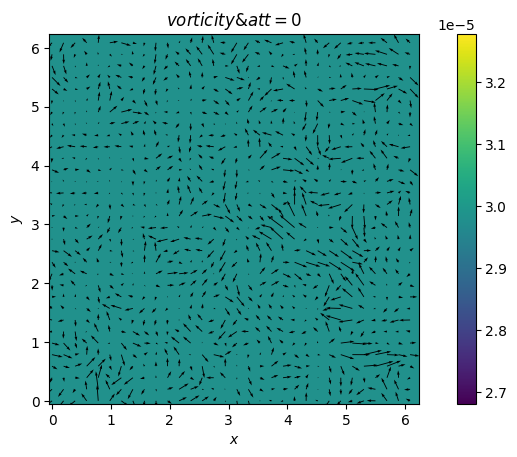

In [21]:
Random.seed!(2234)
dt = 0.025         # the time step
tfin = 100        # the final time for the integration
nstep  = Int(tfin/dt) + 1;  # the total number of time steps
kappa = 3e-04
t = 0:dt:tfin;
kl = 0
ku = 0.8
phi0h = 0.2 .*exp(-im*rand(nx, ny)) #calcula as condições iniciais
phih = phi0h #faz o fourier das condições iniciais
#psih[1, 1] = 0
phih[@. ksq > (ku)^2 ] .= 0
phih[@. ksq < (kl)^2 ] .= 0

#psih = invksq.*psih


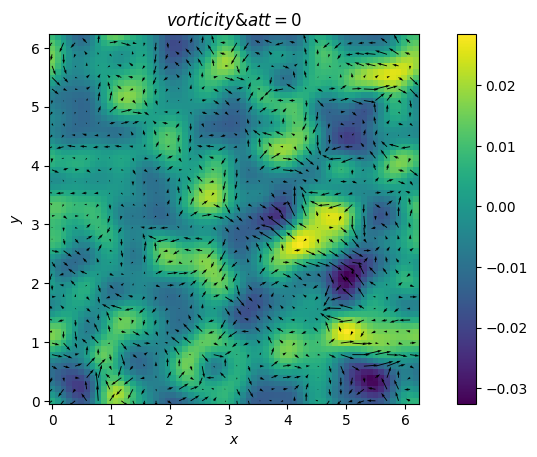

In [35]:
phi = real(ifft(phih))

figure(1)
pcolormesh(X, Y, phi)
colorbar()
quiver(X[1:nc:end,1:nc:end], Y[1:nc:end,1:nc:end], u[1:nc:end,1:nc:end], v[1:nc:end,1:nc:end])
xlabel(L"x")
ylabel(L"y")
title(string(L"vorticity &  at t=", time))
axis("square")
draw();

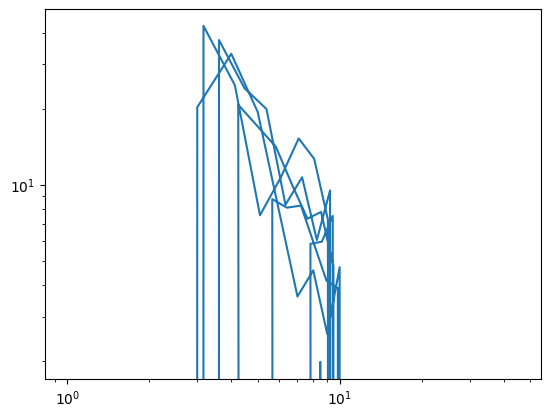

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f40fc2f3850>

In [51]:
u=unique(r)
som = zeros(0)
absphih = @. abs(phih)
for i in u
    coord = (findall(x-> x==i,r))
    push!(som,sum(absphih[coord]))
end
#println(u)
#println(som)
ul = @. log(u)
phihl =@.  log(som)
#plot(ul,phihl)
xscale("log")
yscale("log")
plot(u, som)

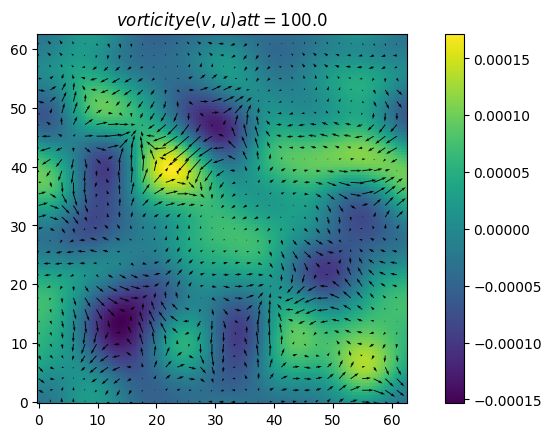

In [39]:
nu = 3e-1
vu = 0.0
time = 0
nc = Int(nx/32)
phi = real(ifft(phih))


fig = figure()

phibk = phi
for j = 2:nstep 
    #phih = invksq.*psih               # calculate \hat{phi}
    psih = phih.*(1 .+ksq)
    u = real(ifft(+im*L.*phih))         # calculate u velocity
    v = real(ifft(+im*K.*phih))         # calculate v velocity
    psix =  real(ifft(im*K.*psih))    # calculate ∂psi/∂x
    psiy =  real(ifft(im*L.*psih))    # calculate ∂psi/∂y

    # now we are ready to calculate the r.h.s. of our PDE
    rhs = -fft(u.*psix - v.*psiy) -vu*fft(v)-nu*kqt .*phih

    
    psih = psih + dt*rhs         # time-step forward using the simplest Euler scheme
    phibk = real(ifft(phih))
    phih = invksq.*psih
    phi = real(ifft(phih))
    if any(isnan, phi)
           println("Entrou")
            println(j)
            println(phibk)
            break
        end
    
    if j % 200 == 1
        time = t[j]
        #phih = -invksq.*psih
        #phi = real(ifft(phih))
        #CSV.write("dados_.csv",DataFrame(psi,:auto),header=false)
        pcolormesh(X, Y, phi)
        #contour(X, Y, phi)
        title(string(L"vorticity at t=", time))
        colorbar()
        quiver(X[1:nc:end,1:nc:end], Y[1:nc:end,1:nc:end], u[1:nc:end,1:nc:end], v[1:nc:end,1:nc:end])
        #xlabel(L"x")
        #ylabel(L"y")
        title(string(L"vorticity e (v,u) at t=", time))
        axis("square")
        sleep(0.05)
        IJulia.clear_output(true)
        display(fig)
        clf()
end
end

In [75]:
phi

LoadError: UndefVarError: `phi` not defined

In [34]:
pi

π = 3.1415926535897...

In [74]:
phi

LoadError: UndefVarError: `phi` not defined

In [113]:
mat = rand(3,3)



3×3 Matrix{Float64}:
 0.740873  0.825344  0.122718
 0.141242  0.219406  0.334937
 0.681483  0.761364  0.377852

In [116]:
ve = zeros( Int( 3*(3+1)/2 ))
c = 1
for i in 1:3
    for j in i:3
        #ve[c] = mat[i,j]
        #c+=1
        println(mat[i,j])
    end
end

0.7408730455472583
0.825343933836133
0.12271793605394721
0.21940612043872854
0.33493668314870806
0.377852359903467
